# HBP SP5 Image Service Performance

This notebook tests and visualizes performance of various deployments of the HBP SP5 image service.

## Python Definitions


Start by runninng the Python code below to define a number of functions that will run the tests and evaluate the results.

**Note**: The log level of the `httpRequest.go` script needs to be set to debug in order for this to work. Only the debug level writes out individual response times.

In [1]:
import numpy
import time
import matplotlib.pyplot as plt
import subprocess
from math import ceil
from scipy import stats

def toMs(s):
    """
    The test script returns timings in the format
    nnn,nn[m]s
    We need to decode the input line, replace commas with dots, and
    normalize to ms.
    """
    s2 = s.decode("UTF-8").replace(",", ".").strip()
    if s2[-2:] == "µs":
        return float(s2[:-2]) / 1000
    if s2[-2:] == "ms":
        return float(s2[:-2])
    elif s2[-1:] == "s":
        return 1000 * float(s2[:-1])
    else:
        return float(s2)
    
def nonZeroLine(l):
    for line in l:
        if line != "0":
            yield line

def runTest(site):
    goBinary = subprocess.Popen("which go", shell=True, stdout=subprocess.PIPE).stdout.read().decode("UTF-8").replace("\n", "")
    
    cmd = "%s run httpRequest.go MetaData.go %s 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/\"//'" % (goBinary, site)

    print(cmd)
    
    sp = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE).stdout

    data = numpy.loadtxt(sp, converters={ 0: toMs })
    return data

def plotData(data):    
    %matplotlib inline
    plt.figure(figsize=(15,5))
    max = 0
    for s in data:
        if data[s].max() > max:
            max = data[s].max()
    max = min(max, 500)
    cmap = plt.get_cmap('jet_r')
    i = 0
    N = len(data)
    for s in data:
        color = cmap(i/N)
        i = i+1
        density = stats.kde.gaussian_kde(data[s])
        #density.set_bandwidth(bw_method=density.factor / 3.)
        #density.set_bandwidth(bw_method='silverman')

        x = numpy.arange(0.,float(max))
        plt.plot(x, density(x), label=s, color=color)
        plt.axvline(data[s].mean(), color=color, ls='dashed')
    #plt.xscale('log')
    plt.xlabel('t (ms)')
    plt.legend()        
    plt.grid(axis='y')
    plt.show()

RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are Working with Matplotlib in a virtual enviroment see 'Working with Matplotlib in Virtual environments' in the Matplotlib FAQ

## Run tests

The following cell runs the actual tests on all configured sites. Resulting data are stored in the 
`data` dictionary.

In [5]:
sites = [
         "http://hbp-image.desy.de:8888",
         "http://hbp-image-service.desy.de",
#         "http://131.169.4.31:8888",
          "http://149.156.9.143:8888",
          "https://fsd-cloud47.zam.kfa-juelich.de",
           "http://fsd-cloud47.zam.kfa-juelich.de"
#        "http://localhost:8000"
]

data = dict()
for site in sites:
    try:
        data[site] = runTest(site)
        print("Image service at %s - SUCCESS" % site)
    except:
        print("Image service at %s - FAIL" % site)

/usr/local/go/bin/go run httpRequest.go MetaData.go http://hbp-image.desy.de:8888 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/"//'


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Image service at http://hbp-image.desy.de:8888 - SUCCESS
/usr/local/go/bin/go run httpRequest.go MetaData.go http://hbp-image-service.desy.de 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/"//'
Image service at http://hbp-image-service.desy.de - FAIL
/usr/local/go/bin/go run httpRequest.go MetaData.go http://149.156.9.143:8888 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/"//'
Image service at http://149.156.9.143:8888 - SUCCESS
/usr/local/go/bin/go run httpRequest.go MetaData.go https://fsd-cloud47.zam.kfa-juelich.de 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/"//'
Image service at https://fsd-cloud47.zam.kfa-juelich.de - SUCCESS
/usr/local/go/bin/go run httpRequest.go MetaData.go http://fsd-cloud47.zam.kfa-juelich.de 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/"//'
Image service at http://fsd-cloud47.zam.kfa-juelich.de - SUCCESS


## Plot Results

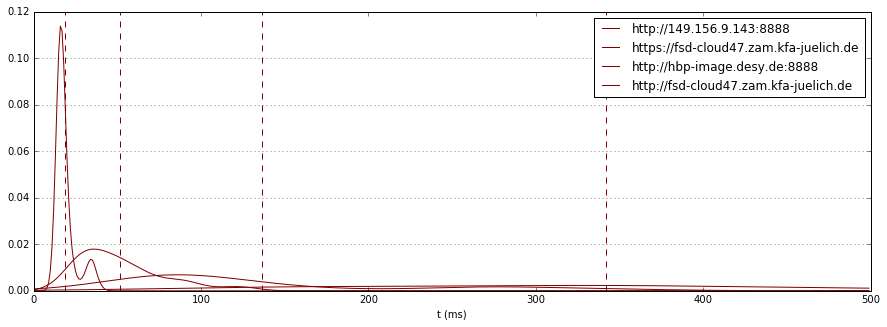

In [6]:
#del data['http://149.156.9.143:8888']
#for site in sites:
#    plotData(data[site])
plotData(data)